In [1]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

C:\Users\Erfan\anaconda3\envs\tf21gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import os
import numpy as np
import pandas as pd

X = []
y = []

base_dir = "eeg_csv_frames/"   # Main Root

for subject in os.listdir(base_dir):
    subject_dir = os.path.join(base_dir, subject, "Normalized")
    if not os.path.isdir(subject_dir):
        continue

    label = 1 if subject.lower().startswith("s") else 0

    for file in os.listdir(subject_dir):
        if "zscore_l2" in file and file.endswith(".csv"):
            file_path = os.path.join(subject_dir, file)
            df = pd.read_csv(file_path)
            X.append(df.to_numpy())
            y.append(label)

X = np.array(X)
y = np.array(y)

print("✅ Total Frames:", X.shape[0], "| Shape:", X.shape, "| Labels:", y.shape)


✅ Total Frames: 1142 | Shape: (1142, 6250, 19) | Labels: (1142,)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [4]:
print(f"X_train shape is : {X_train.shape}")
print(f"X_val shape is : {X_val.shape}")
print("---------------------------------")
print(f"y_train shape is : {y_train.shape}")
print(f"y_val shape is : {y_val.shape}")

X_train shape is : (913, 6250, 19)
X_val shape is : (229, 6250, 19)
---------------------------------
y_train shape is : (913,)
y_val shape is : (229,)


In [10]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Number of Folds
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

acc_scores = []
val_losses = []

fold = 1
for train_index, val_index in skf.split(X, y):
    print(f"\n📂 Fold {fold} / {k_folds}")
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Make a new model for each Fold
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(6250, 19)),
        Conv1D(64, 3, activation='relu'),
        Dropout(0.5),
        MaxPooling1D(pool_size=2),
        LSTM(100),
        Dropout(0.5),
        Dense(100),
        Dropout(0.25),
        Dense(50, activation='relu'),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping اختیاری
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=16,
        callbacks=[early_stop],
        verbose=0 
    )

    # The Maximum Of the Fold Accuracy
    val_acc = max(history.history['val_accuracy'])
    val_loss = min(history.history['val_loss'])

    acc_scores.append(val_acc)
    val_losses.append(val_loss)

    print(f"✅ Fold {fold} - Best Val Accuracy: {val_acc:.4f} | Min Val Loss: {val_loss:.4f}")
    fold += 1

# Mean and STD
print("\n📊 Cross-validation result:")
print(f"📈 Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"📉 Val Loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")



📂 Fold 1 / 5
✅ Fold 1 - Best Val Accuracy: 0.9345 | Min Val Loss: 0.1836

📂 Fold 2 / 5
✅ Fold 2 - Best Val Accuracy: 0.9039 | Min Val Loss: 0.2722

📂 Fold 3 / 5
✅ Fold 3 - Best Val Accuracy: 0.9211 | Min Val Loss: 0.2351

📂 Fold 4 / 5
✅ Fold 4 - Best Val Accuracy: 0.9079 | Min Val Loss: 0.2587

📂 Fold 5 / 5
✅ Fold 5 - Best Val Accuracy: 0.9474 | Min Val Loss: 0.1738

📊 Cross-validation result:
📈 Accuracy: 0.9229 ± 0.0163
📉 Val Loss: 0.2247 ± 0.0395


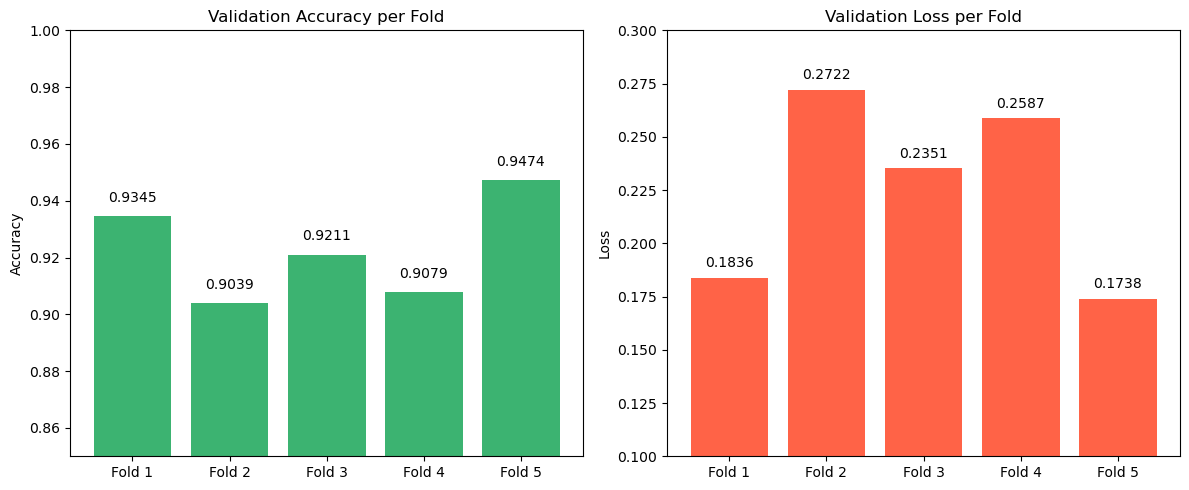

In [13]:
import matplotlib.pyplot as plt
import numpy as np

folds = [f"Fold {i+1}" for i in range(len(acc_scores))]

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(folds, acc_scores, color='mediumseagreen')
plt.ylim(0.85, 1.0)
plt.title("Validation Accuracy per Fold")
plt.ylabel("Accuracy")
for i, v in enumerate(acc_scores):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')

# Loss
plt.subplot(1, 2, 2)
plt.bar(folds, val_losses, color='tomato')
plt.ylim(0.1, 0.3)
plt.title("Validation Loss per Fold")
plt.ylabel("Loss")
for i, v in enumerate(val_losses):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.savefig("crossval_bar_chart.png", dpi=300)
plt.show()


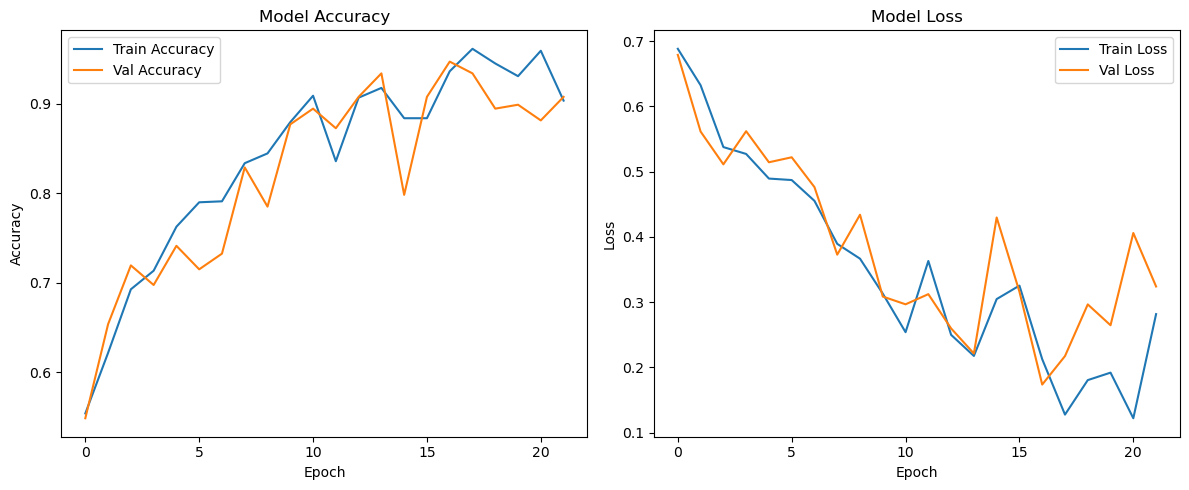

In [34]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"saved_model/h5/Training_chart_{str_acc}.png", dpi=300)
    plt.show()

plot_history(history)


In [14]:
best_val_acc = max(history.history['val_accuracy'])
print(f"📈 Best Validation Accuracy: {best_val_acc:2f}")

📈 Best Validation Accuracy: 0.947368


In [15]:
# Predictions
y_pred_prob = model.predict(X_val).flatten()
y_pred_class = (y_pred_prob >= 0.5).astype(int)


8/8 [==============================] - 2s 145ms/step


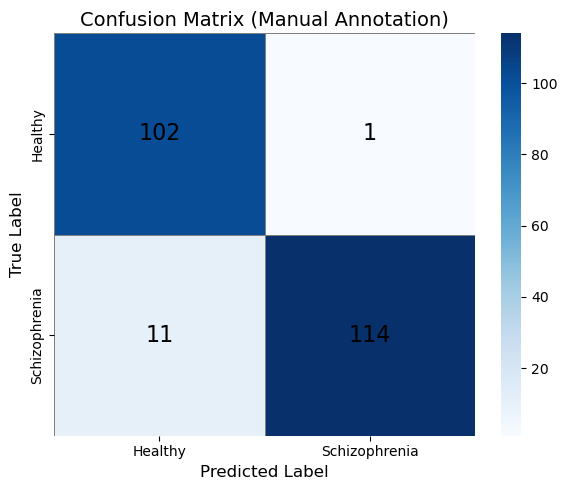

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_val, y_pred_class)
labels = ['Healthy', 'Schizophrenia']

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                 xticklabels=labels, yticklabels=labels,
                 linewidths=0.5, linecolor='gray')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        ax.text(j + 0.5, i + 0.5, str(value),
                ha='center', va='center',
                color='black', fontsize=16)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix (Manual Annotation)', fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_final.png", dpi=300)
plt.show()


In [31]:
from sklearn.metrics import confusion_matrix, classification_report

# Precision, Recall, F1-score
print("\nClassification Report:\n", classification_report(y_val, y_pred_class, digits=4))



Classification Report:
               precision    recall  f1-score   support

           0     0.9027    0.9903    0.9444       103
           1     0.9913    0.9120    0.9500       125

    accuracy                         0.9474       228
   macro avg     0.9470    0.9511    0.9472       228
weighted avg     0.9513    0.9474    0.9475       228



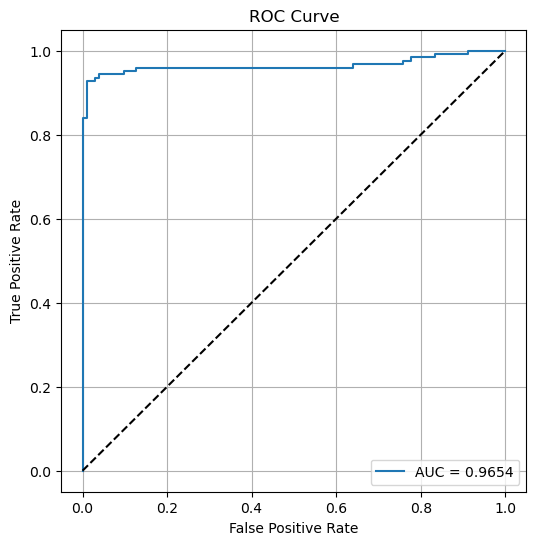

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [33]:
str_acc = f"{best_val_acc:.2f}"
str_acc = str_acc[2:]

os.makedirs(f"saved_model/h5", exist_ok=True)

model.save(f"saved_model/h5/cnn_lstm_schizophrenia_{str_acc}.h5")

model.save(f"saved_model/cnn_lstm_schizophrenia_{str_acc}")


INFO:tensorflow:Assets written to: saved_model/cnn_lstm_schizophrenia_95\assets


INFO:tensorflow:Assets written to: saved_model/cnn_lstm_schizophrenia_95\assets


In [43]:
i = np.random.randint(228)
sample = X_val[i]
true_label = y_val[i]

sample_input = np.expand_dims(sample, axis=0)

# Predict
pred_prob = model.predict(sample_input)[0][0]
pred_class = int(pred_prob >= 0.5)

# Print Resaults
labels = ['Healthy', 'Schizophrenia']
print(f"number of the chosen Sample is : {i}")
print(f"🎯 True Label: {labels[true_label]}")
print(f"🤖 Predicted Label: {labels[pred_class]}  (prob: {pred_prob:.4f})")


1/1 [==============================] - 0s 221ms/step
number of the chosen Sample is : 21
🎯 True Label: Healthy
🤖 Predicted Label: Healthy  (prob: 0.1249)
